<a href="https://colab.research.google.com/github/habibur-rahman-swe/complete-paddy-prediction/blob/main/GoogleEarthImageAnalysisDemo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import geopandas as gpd

In [2]:
ee.Authenticate()
project_id = 'complete-prediction'
ee.Initialize(project=project_id)

Total area of rice paddies in Bangladesh: 4878.006927676416 square kilometers


TypeError: Colorbar.__init__() got an unexpected keyword argument 'bricks'

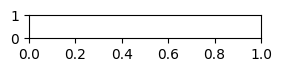

In [5]:
# Define the region of interest (Bangladesh)
bangladesh = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Bangladesh'))

# Load a satellite image collection (Sentinel-2)
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate('2024-01-01', '2024-12-31').filterBounds(bangladesh)

# Function to mask clouds
def maskClouds(image):
    cloud_prob = image.select('QA60')
    return image.updateMask(cloud_prob.lt(1))

# Apply the cloud masking function
sentinel2 = sentinel2.map(maskClouds)

# Create a median composite image
median_image = sentinel2.median().clip(bangladesh)

# Define a vegetation index (NDVI)
ndvi = median_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Threshold NDVI to classify rice paddies (assuming high NDVI values indicate rice paddies)
rice_paddies = ndvi.gt(0.5).selfMask()

# Calculate the area of rice paddies
area_image = rice_paddies.multiply(ee.Image.pixelArea())
area = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=bangladesh.geometry(),
    scale=30,
    maxPixels=1e9
)

# Get the area in square kilometers
rice_paddy_area_sq_km = area.getInfo()['NDVI'] / 1e6
print(f'Total area of rice paddies in Bangladesh: {rice_paddy_area_sq_km} square kilometers')

# Visualize the results
Map = geemap.Map()
Map.centerObject(bangladesh, 7)
Map.addLayer(median_image, {'bands': ['B4', 'B3', 'B2'], 'max': 3000}, 'Sentinel-2')
Map.addLayer(rice_paddies, {'palette': 'green'}, 'Rice Paddies')
Map.addLayer(bangladesh, {}, 'Bangladesh')
Map.add_colorbar(bricks=['green'], vmin=0, vmax=1, label="Rice Paddies", layer_name="Rice Paddies")
Map